<a href="https://colab.research.google.com/github/mamontovatetiana/MyJupyterNotebooks./blob/main/Mamontova_TV_Bachelor_Diploma_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ====== КРОК -1.0: Імпорт та завантаження ======
from google.colab import files
import io, re, numpy as np, pandas as pd

uploaded = files.upload()  # обери свій .xlsx
file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))
print("Shape:", df.shape); display(df.head(3))


Saving PYTHON MODELING.csv.xlsx to PYTHON MODELING.csv.xlsx
Shape: (252, 19)


,year,year train year test,Gender,Age,Family living nearby,Marital status,Working Status,Internally Displaced Persons,GPA,Current Smokers,Current Drinkers,Deceased Relatives,Сombatants,Anxiety GAD 7,Depression PHQ 9,Avoidance Subscale IESR,Intrusion Subscale IESR,Hyperarousal Subscale IESR,PTSD HTQ 5
0,2023,2023,0,21,0,0,0,0,3.7,0,1,0,0,4,0,1,0,3,0
1,2023,2023,0,21,0,0,1,1,3.5,0,1,0,0,5,9,14,14,7,0
2,2023,2023,0,22,1,0,0,1,4.6,0,0,0,0,2,1,0,2,0,0


In [2]:
# ====== КРОК -1.1: Пошук IES/HTQ та побудова цільової 'Vulnerability' ======
# Порогові значення зі статей: IES-R ≥ 33; HTQ-5 ≥ 2.5
IES_THR, HTQ_THR = 33.0, 2.5

# 1) знайдемо total IES або відбудуємо з підшкал
ies_total_col = None
ies_total_candidates = [c for c in df.columns if re.search(r'(total.*ies|ies.*total|total mean ies|ies_total_computed)', c, re.I)]
ies_sub_cols = [c for c in df.columns if re.search(r'(avoidance.*iesr|intrusion.*iesr|hyperarousal.*iesr)', c, re.I)]
if ies_total_candidates:
    ies_total_col = ies_total_candidates[0]
elif len(ies_sub_cols) >= 3:
    for c in ies_sub_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['IES_total_computed'] = df[ies_sub_cols].sum(axis=1, skipna=True)
    ies_total_col = 'IES_total_computed'

# 2) знайдемо HTQ-5
htq_col = None
htq_candidates = [c for c in df.columns if re.search(r'(htq\s*-?\s*5|htq5|htq)', c, re.I)]
if htq_candidates:
    htq_col = htq_candidates[0]

print("IES total:", ies_total_col)
print("HTQ-5:", htq_col)

# 3) числові таргети
if ies_total_col is not None:
    df[ies_total_col] = pd.to_numeric(df[ies_total_col], errors='coerce')
    df['target_IES'] = (df[ies_total_col] >= IES_THR).astype(int)
else:
    df['target_IES'] = 0

if htq_col is not None:
    df[htq_col] = pd.to_numeric(df[htq_col], errors='coerce')
    df['target_HTQ'] = (df[htq_col] >= HTQ_THR).astype(int)
else:
    df['target_HTQ'] = 0

# 4) Основна мітка (логіка OR за статтями): хоча б один позитивний
df['Vulnerability'] = ((df['target_IES']==1) | (df['target_HTQ']==1)).astype(int)

# короткий звіт
print("\n=== PREVALENCE OVERALL ===")
print(df['Vulnerability'].value_counts().rename('count'))
print("share(1):", df['Vulnerability'].mean().round(3))

# за роками, якщо є
year_col = None
for c in df.columns:
    if df[c].astype(str).str.contains(r'20(23|24|25)').any():
        year_col = c; break
if year_col:
    tmp = df.copy()
    tmp[year_col] = tmp[year_col].astype(str).str.extract(r'(20\d{2})', expand=False)
    print("\n=== PREVALENCE BY YEAR ===")
    display(tmp.groupby(year_col)['Vulnerability'].agg(['count','sum','mean']))
else:
    print("Year column not found (ok).")


IES total: IES_total_computed
HTQ-5: PTSD HTQ 5

=== PREVALENCE OVERALL ===
Vulnerability
0    191
1     61
Name: count, dtype: int64
share(1): 0.242

=== PREVALENCE BY YEAR ===


/tmp/ipython-input-3666496243.py:50: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df[c].astype(str).str.contains(r'20(23|24|25)').any():


,count,sum,mean
year,,,
2023,130,32,0.246154
2024,32,9,0.281250
2025,90,20,0.222222


In [3]:
# ====== КРОК -1.2: Кодування категорій (Label + One-Hot), без витоків ======
from sklearn.preprocessing import LabelEncoder

df_enc = df.copy()

# (а) текстові → розділимо на бінарні (LabelEncoder) та з ≤10 рівнів (One-Hot)
cat_cols = [c for c in df_enc.columns if df_enc[c].dtype=='object']
label_cols, onehot_cols = [], []
for c in cat_cols:
    nun = df_enc[c].nunique(dropna=True)
    if nun <= 2: label_cols.append(c)
    elif nun <= 10: onehot_cols.append(c)
    # якщо більше 10 — часто краще Label, але обережно; поки пропустимо

le_map = {}
for c in label_cols:
    le = LabelEncoder()
    df_enc[c+'_le'] = le.fit_transform(df_enc[c].astype(str))
    le_map[c] = le

df_enc = pd.get_dummies(df_enc, columns=onehot_cols, drop_first=True)
print("Encoded shape:", df_enc.shape)


Encoded shape: (252, 23)


In [4]:
# ====== КРОК -1.3: Вибір фіч (features) БЕЗ витоків і технічних колонок ======
# Витоки (leak): ніяких IES/HTQ або їх підшкал у фічах.
leak_cols = []
if ies_total_col: leak_cols.append(ies_total_col)
if htq_col: leak_cols.append(htq_col)
leak_cols += ies_sub_cols

# Технічні колонки (наприклад, 'year train year test')
tech_patterns = [r'train', r'test', r'year\s*train\s*year\s*test']
tech_cols = [c for c in df_enc.columns if any(re.search(p, c, re.I) for p in tech_patterns)]

# Таргети/службові
exclude_base = ['Vulnerability','target_IES','target_HTQ']

# id-подібні
id_like = [c for c in df_enc.columns if re.search(r'(№|id|код|index)', str(c), re.I)]

# Забороняємо використовувати рік як фічу (використовуємо тільки для розбиття/репорту)
exclude = set(exclude_base + leak_cols + tech_cols + id_like)
all_numeric = [c for c in df_enc.select_dtypes(include=[np.number]).columns]
features = [c for c in all_numeric if c not in exclude and (year_col is None or c != year_col)]

print("Features (count):", len(features))
print(features)


Features (count): 13
['Gender', 'Age', 'Family living nearby', 'Marital status', 'Working Status', 'Internally Displaced Persons ', 'GPA', 'Current Smokers', 'Current Drinkers', 'Deceased Relatives', 'Сombatants', 'Anxiety GAD 7', 'Depression PHQ 9']


In [5]:
# ====== КРОК -1.4: Стандартизація ======
from sklearn.preprocessing import StandardScaler

df_model = df_enc[~df_enc['Vulnerability'].isna()].copy()
X = df_model[features].fillna(0)
y = df_model['Vulnerability'].astype(int)

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
print("X_sc:", X_sc.shape, "y:", y.shape)


X_sc: (252, 13) y: (252,)


In [6]:
# ====== КРОК 2.1: Стратифікований 80/20 (рекомендовано для твоїх даних) ======
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y.values, test_size=0.2, stratify=y, random_state=42
)
print("Train classes:", np.unique(y_train, return_counts=True))
print("Test  classes:", np.unique(y_test,  return_counts=True))


Train classes: (array([0, 1]), array([152,  49]))
Test  classes: (array([0, 1]), array([39, 12]))


In [7]:
# ====== КРОК 2.2: Балансування (SMOTE) лише на train ======
!pip -q install imbalanced-learn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.unique(y_train_sm, return_counts=True))


After SMOTE: (array([0, 1]), array([152, 152]))


In [9]:
# ====== КРОК 2.3: Модель 1 — Decision Tree ======
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

cw_vals = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls:w for cls,w in zip(np.unique(y_train), cw_vals)}

dt = DecisionTreeClassifier(max_depth=4, class_weight=class_weights, random_state=42)
dt.fit(X_train_sm, y_train_sm)
y_pred_dt  = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:,1]


In [10]:
# ====== КРОК 2.4: Модель 2 — XGBoost (з GridSearchCV) ======
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV

xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
param_grid = {'n_estimators':[100,200], 'max_depth':[3,5], 'learning_rate':[0.01,0.05,0.1]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(xgb_clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
gs.fit(X_train_sm, y_train_sm)
best_xgb = gs.best_estimator_
print("Best XGB params:", gs.best_params_)

y_pred_xgb  = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]


Best XGB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [11]:
# ====== КРОК 2.5: Порівняння моделей ======
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import pandas as pd

def metrics(y_true, y_pred, y_proba):
    return {
        'accuracy':  accuracy_score(y_true,y_pred),
        'precision': precision_score(y_true,y_pred, zero_division=0),
        'recall':    recall_score(y_true,y_pred, zero_division=0),
        'f1':        f1_score(y_true,y_pred, zero_division=0),
        'roc_auc':   roc_auc_score(y_true,y_proba)
    }

summary = pd.DataFrame({
    'DecisionTree': metrics(y_test, y_pred_dt,  y_proba_dt),
    'XGBoost':      metrics(y_test, y_pred_xgb, y_proba_xgb),
}).T
display(summary)


,accuracy,precision,recall,f1,roc_auc
DecisionTree,0.666667,0.400000,0.833333,0.540541,0.756410
XGBoost,0.784314,0.533333,0.666667,0.592593,0.792735


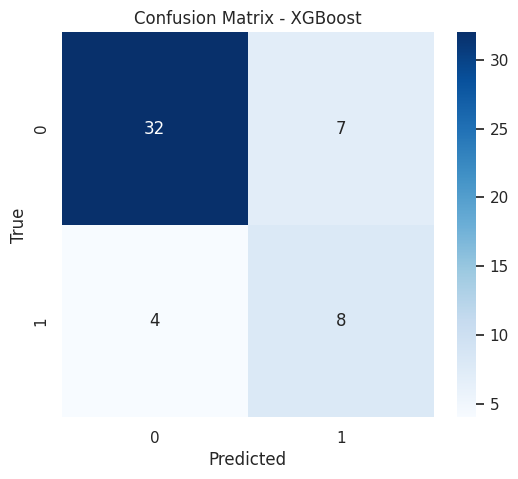

XGBoost classification report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85        39
           1       0.53      0.67      0.59        12

    accuracy                           0.78        51
   macro avg       0.71      0.74      0.72        51
weighted avg       0.81      0.78      0.79        51



In [12]:
# ====== КРОК 3.1: Confusion Matrix для XGBoost ======
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
sns.set(style='whitegrid'); plt.rcParams['figure.figsize']=(6,5)

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

print("XGBoost classification report:\n", classification_report(y_test, y_pred_xgb))


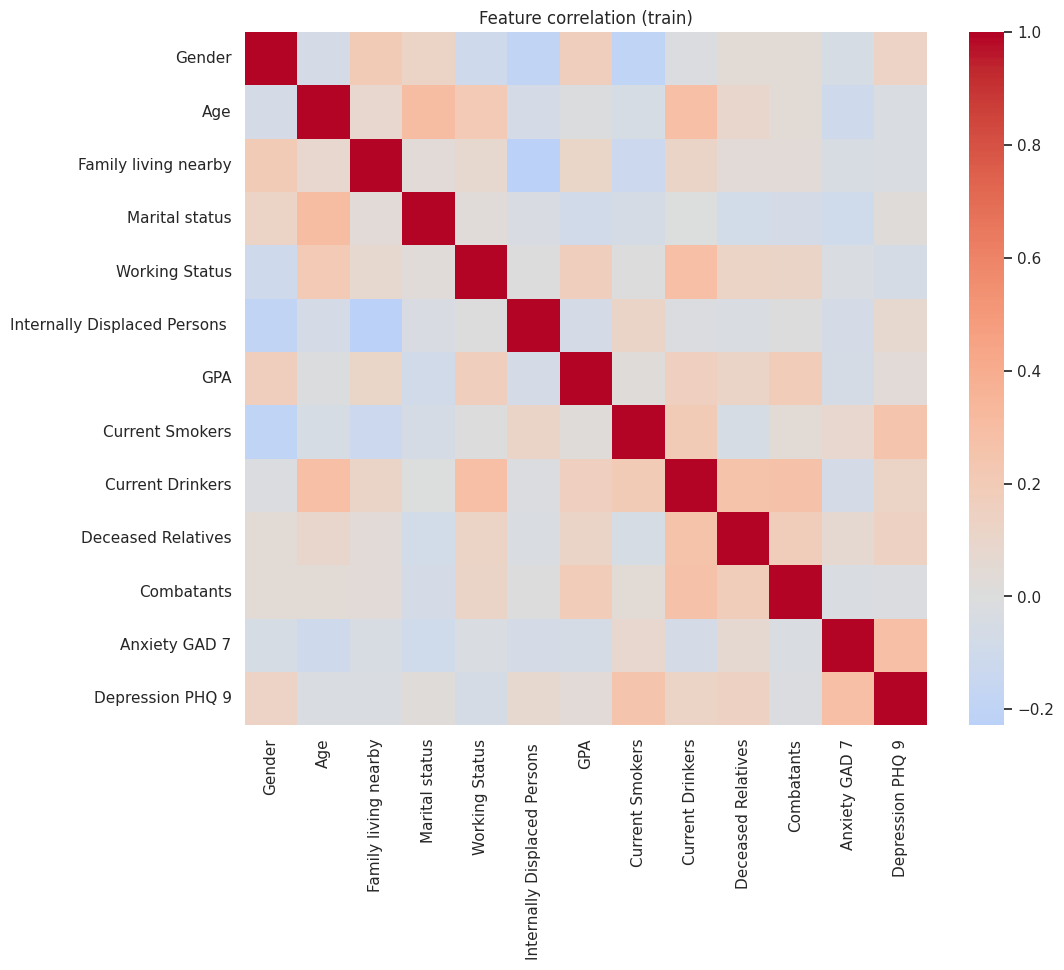

In [13]:
# ====== КРОК 3.2: Heatmap кореляцій фіч (на train) ======
corr = pd.DataFrame(X_train, columns=features).corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature correlation (train)'); plt.show()


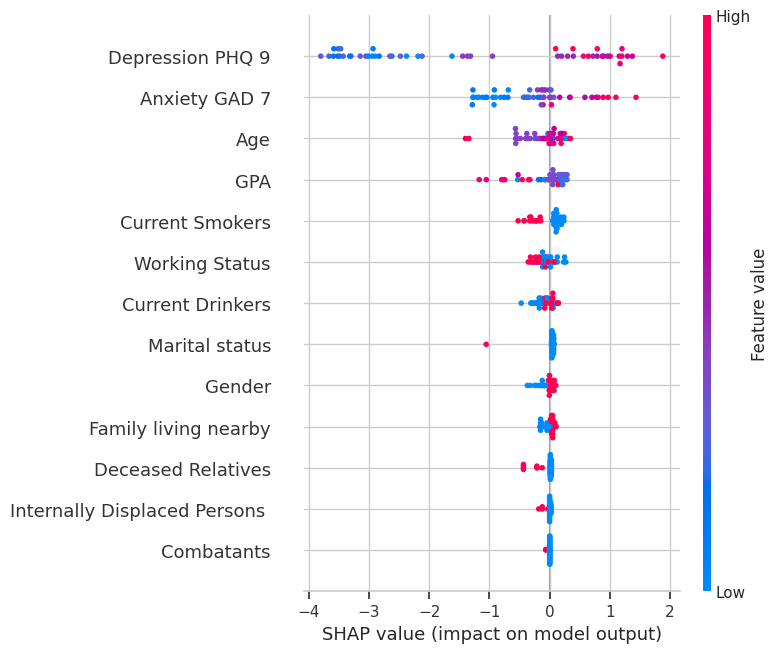

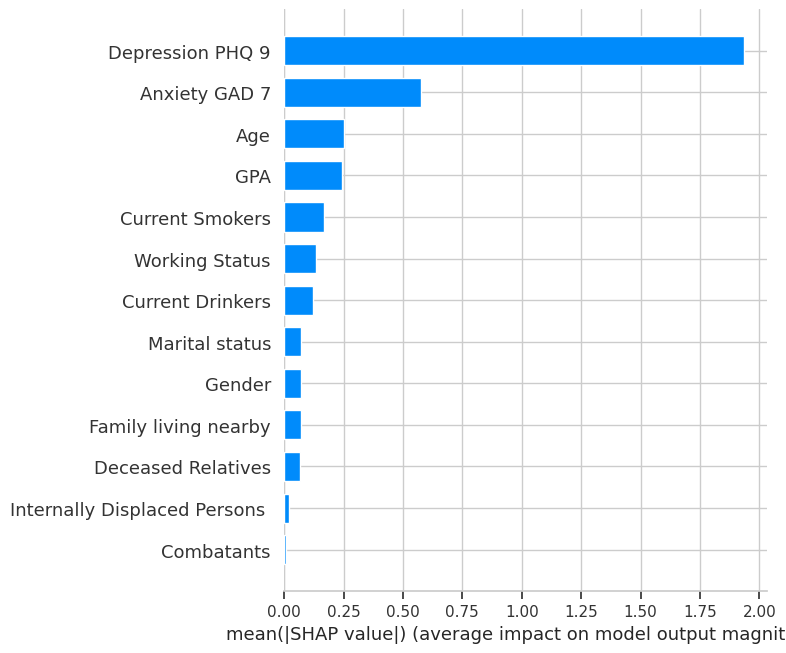

In [14]:
# ====== КРОК 4: SHAP (summary + bar) для XGBoost ======
import shap, numpy as np
explainer = shap.TreeExplainer(best_xgb)
idx = np.random.choice(X_test.shape[0], min(200, X_test.shape[0]), replace=False)
X_sample = X_test[idx]
shap_vals = explainer.shap_values(X_sample)

shap.summary_plot(shap_vals, pd.DataFrame(X_sample, columns=features), show=True)
shap.summary_plot(shap_vals, pd.DataFrame(X_sample, columns=features), plot_type='bar', show=True)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


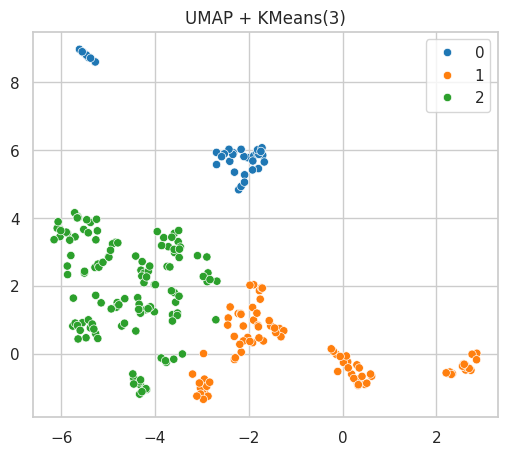

,count,sum,mean
cluster_k3,,,
0,38,11,0.289474
1,87,23,0.264368
2,127,27,0.212598


Saved: /content/PREP_with_clusters.csv


In [15]:
# ====== КРОК 5: UMAP (або PCA) + KMeans(3) ======
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(X_sc)
    method_name = "UMAP"
except Exception as e:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X_sc)
    method_name = "PCA (fallback)"
    print("UMAP not available, using PCA. Err:", e)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_2d)
labels = kmeans.labels_

sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, palette='tab10')
plt.title(f'{method_name} + KMeans(3)'); plt.show()

df_clusters = df_model.copy().reset_index(drop=True)
df_clusters['dim0'] = X_2d[:,0]
df_clusters['dim1'] = X_2d[:,1]
df_clusters['cluster_k3'] = labels
display(df_clusters.groupby('cluster_k3')['Vulnerability'].agg(['count','sum','mean']))

# збережемо версію для звіту/додатків
df_clusters.to_csv('/content/PREP_with_clusters.csv', index=False)
print("Saved: /content/PREP_with_clusters.csv")


MLP report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.46      0.50      0.48        12

    accuracy                           0.75        51
   macro avg       0.65      0.66      0.66        51
weighted avg       0.75      0.75      0.75        51

ROC-AUC (MLP): 0.6965811965811965


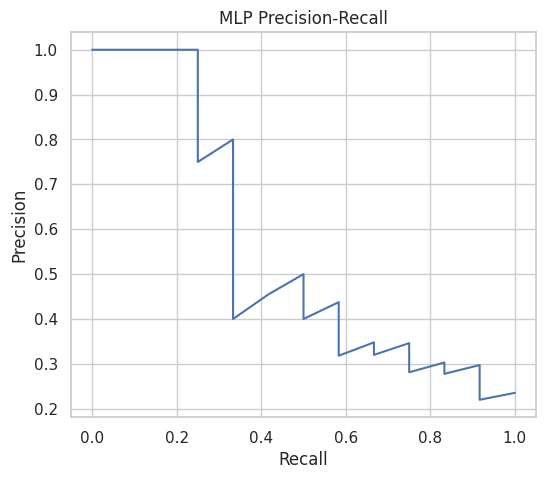

MLP threshold for Recall≥0.8: thr=0.000, Precision=0.303, Recall=0.833
MLP@thr report:
               precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.30      0.83      0.44        12

    accuracy                           0.51        51
   macro avg       0.60      0.62      0.50        51
weighted avg       0.75      0.51      0.53        51



In [16]:
# ====== КРОК 6.1: MLP (BPNN) ======
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, auc

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
mlp.fit(X_train_sm, y_train_sm)
y_pred_mlp  = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print("MLP report:\n", classification_report(y_test, y_pred_mlp))
print("ROC-AUC (MLP):", roc_auc_score(y_test, y_proba_mlp))

# PR-крива + приклад вибору порогу під Recall>=0.80
prec, rec, thr = precision_recall_curve(y_test, y_proba_mlp)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("MLP Precision-Recall"); plt.show()
target_recall = 0.80
cands = [(p,r,t) for p,r,t in zip(prec,rec, np.append(thr,1.0)) if r>=target_recall]
if cands:
    best = max(cands, key=lambda x:x[0])
    sel_thr = best[2]
    print(f"MLP threshold for Recall≥{target_recall}: thr={sel_thr:.3f}, Precision={best[0]:.3f}, Recall={best[1]:.3f}")
    y_pred_mlp_thr = (y_proba_mlp >= sel_thr).astype(int)
    print("MLP@thr report:\n", classification_report(y_test, y_pred_mlp_thr))


  0%|          | 0/51 [00:00<?, ?it/s]

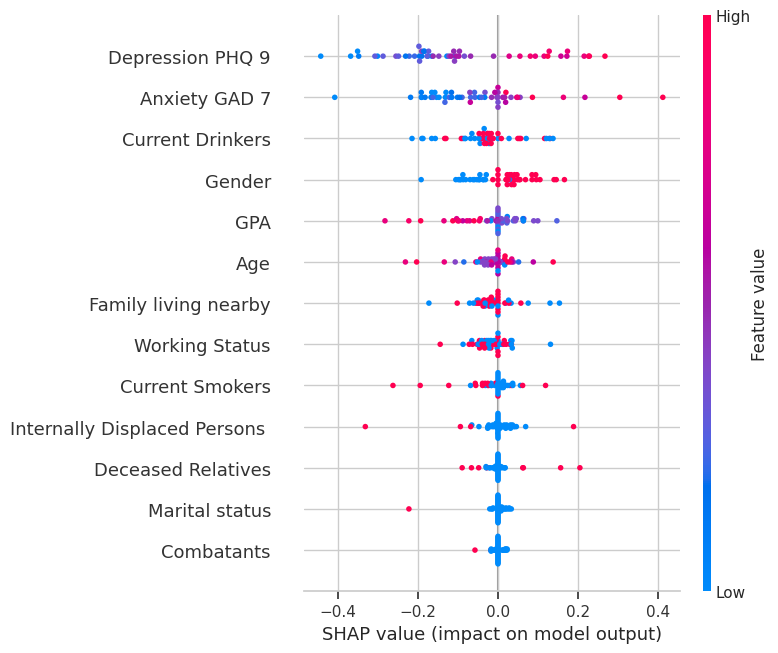

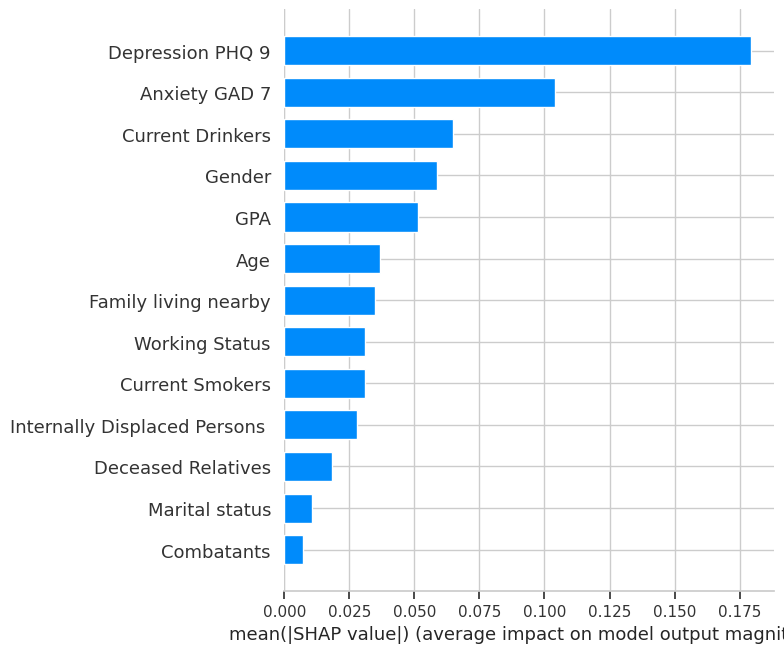

In [17]:
# ====== КРОК 6.2: SHAP для MLP (KernelExplainer; повільно — беремо невеликий семпл) ======
import shap, numpy as np
# ф-ція прогнозу ймовірності класу 1
f = lambda X_: mlp.predict_proba(X_)[:,1]

# невеликий background і sample для швидкості
bg_idx = np.random.choice(X_train_sm.shape[0], min(100, X_train_sm.shape[0]), replace=False)
X_bg = X_train_sm[bg_idx]
te_idx = np.random.choice(X_test.shape[0], min(80, X_test.shape[0]), replace=False)
X_te_small = X_test[te_idx]

kernel_expl = shap.KernelExplainer(f, X_bg)
shap_vals_nn = kernel_expl.shap_values(X_te_small, nsamples=100)  # збільшиш nsamples якщо буде швидко

shap.summary_plot(shap_vals_nn, pd.DataFrame(X_te_small, columns=features), show=True)
shap.summary_plot(shap_vals_nn, pd.DataFrame(X_te_small, columns=features), plot_type='bar', show=True)


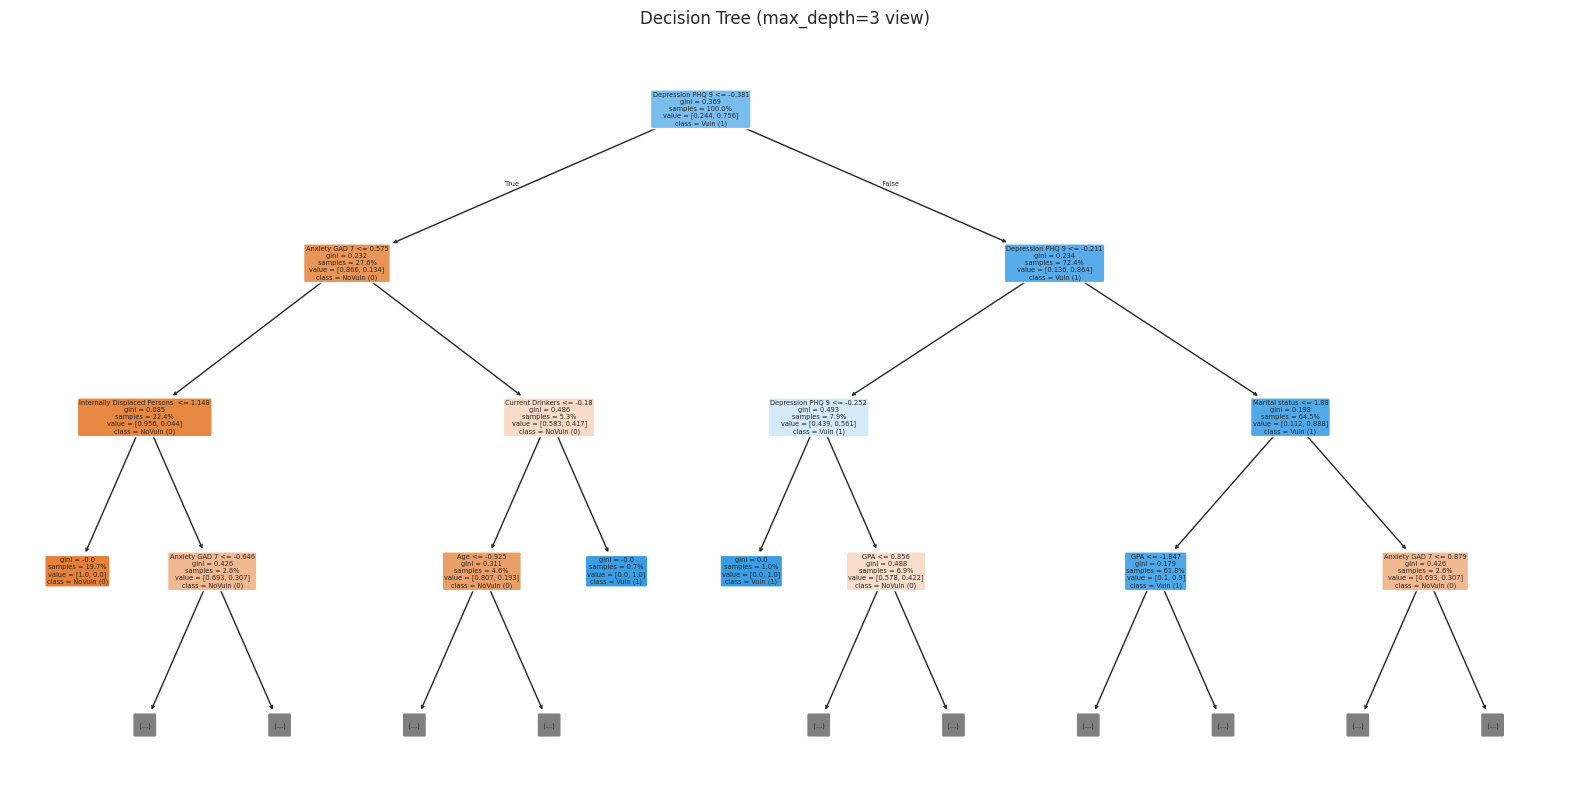

In [18]:
# === ВІЗУАЛІЗАЦІЯ СТРУКТУРИ DECISION TREE ===
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=features,
    class_names=['NoVuln (0)', 'Vuln (1)'],
    filled=True,
    rounded=True,
    impurity=True,       # Gini інфо
    proportion=True,     # частки в листках
    max_depth=3          # щоб було читабельно; змінюй за потреби
)
plt.title("Decision Tree (max_depth=3 view)")
plt.show()


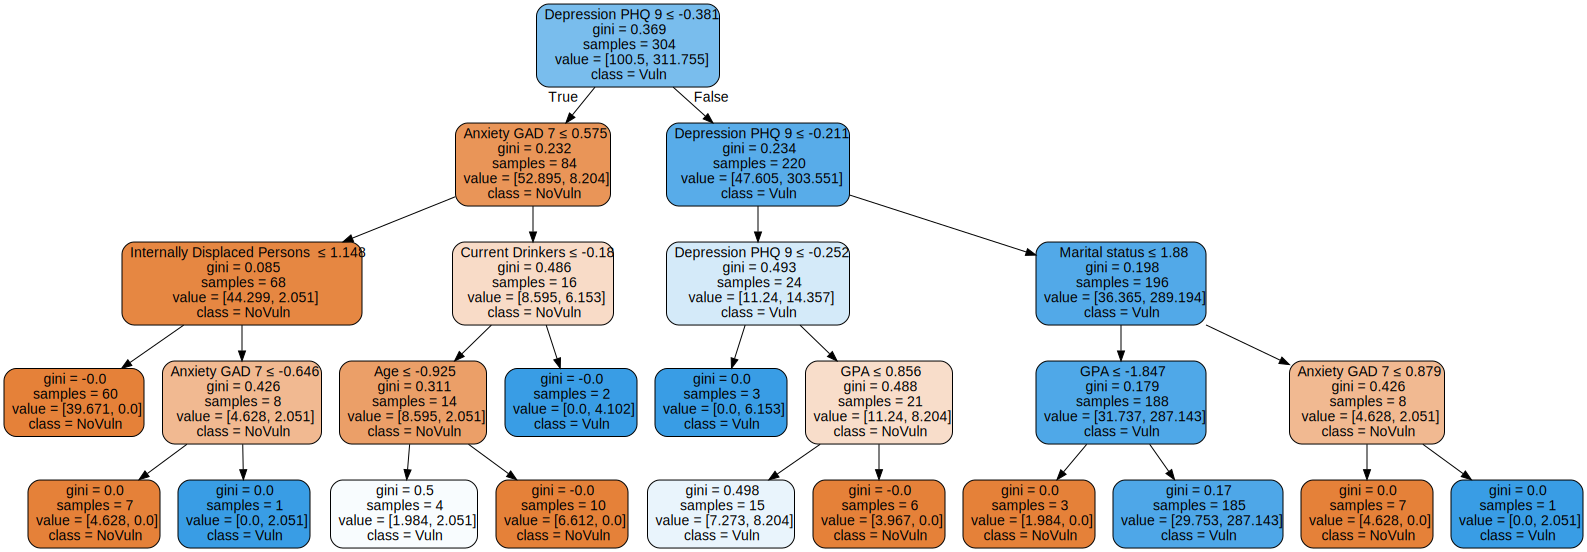

In [19]:
!apt-get -qq install graphviz > /dev/null
!pip -q install graphviz
from sklearn.tree import export_graphviz
import graphviz
dot = export_graphviz(dt, out_file=None, feature_names=features,
                      class_names=['NoVuln','Vuln'], filled=True, rounded=True,
                      special_characters=True, max_depth=None)
graph = graphviz.Source(dot); graph


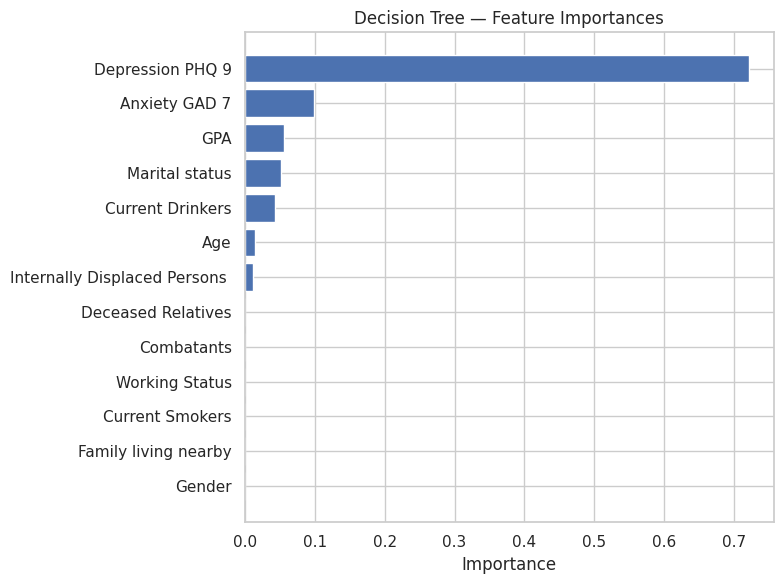

In [20]:
import numpy as np
import matplotlib.pyplot as plt

importances = dt.feature_importances_
idx = np.argsort(importances)[::-1]
top_n = min(15, len(features))

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[idx[:top_n]][::-1], importances[idx[:top_n]][::-1])
plt.title("Decision Tree — Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


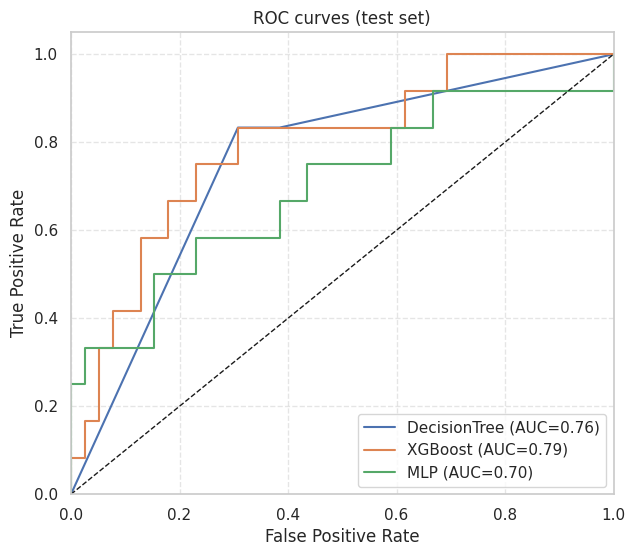

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "DecisionTree": y_proba_dt,
    "XGBoost":      y_proba_xgb,
    "MLP":          y_proba_mlp
}

plt.figure(figsize=(7,6))
for name, proba in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1], 'k--', linewidth=1)
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (test set)")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


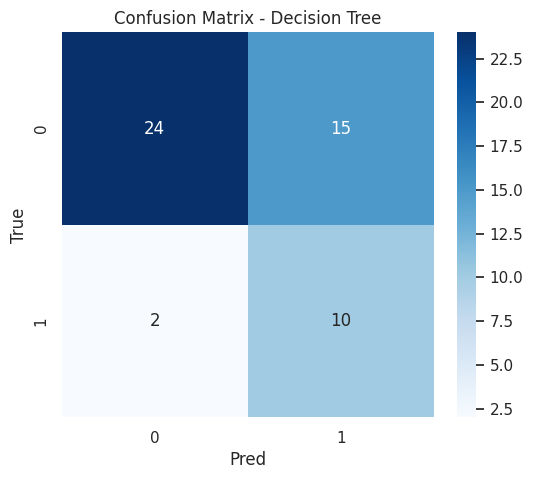

Decision Tree report:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74        39
           1       0.40      0.83      0.54        12

    accuracy                           0.67        51
   macro avg       0.66      0.72      0.64        51
weighted avg       0.80      0.67      0.69        51



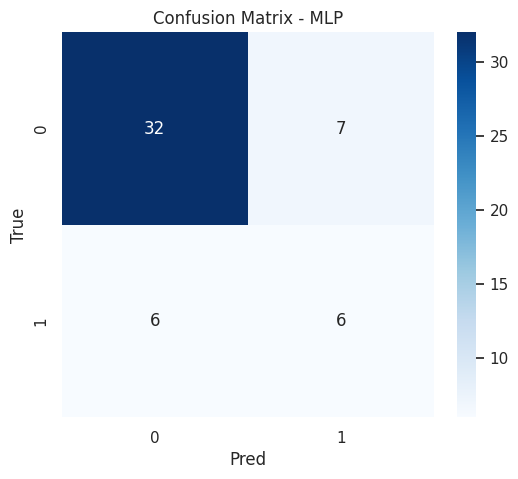

MLP report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.46      0.50      0.48        12

    accuracy                           0.75        51
   macro avg       0.65      0.66      0.66        51
weighted avg       0.75      0.75      0.75        51



In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()
print("Decision Tree report:\n", classification_report(y_test, y_pred_dt))

# MLP
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MLP'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()
print("MLP report:\n", classification_report(y_test, y_pred_mlp))


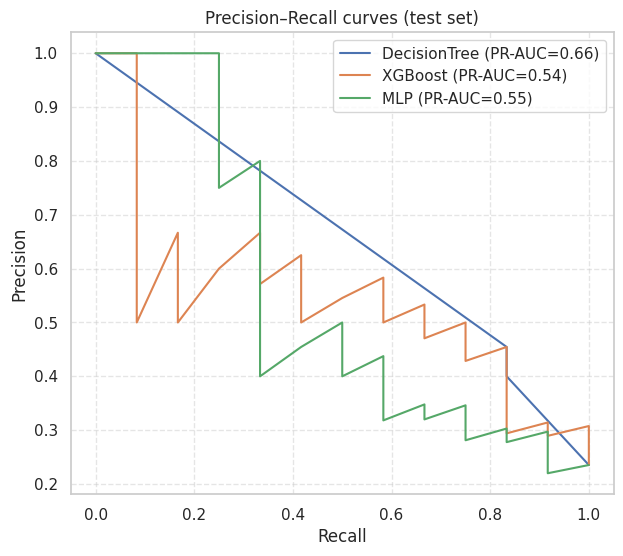

In [23]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(7,6))
for name, proba in models.items():
    prec, rec, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} (PR-AUC={pr_auc:.2f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curves (test set)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Розрахунок метрик
results = {
    "DecisionTree": {
        "accuracy": accuracy_score(y_test, y_pred_dt),
        "precision": precision_score(y_test, y_pred_dt),
        "recall": recall_score(y_test, y_pred_dt),
        "f1": f1_score(y_test, y_pred_dt),
        "roc_auc": roc_auc_score(y_test, y_proba_dt)
    },
    "XGBoost": {
        "accuracy": accuracy_score(y_test, y_pred_xgb),
        "precision": precision_score(y_test, y_pred_xgb),
        "recall": recall_score(y_test, y_pred_xgb),
        "f1": f1_score(y_test, y_pred_xgb),
        "roc_auc": roc_auc_score(y_test, y_proba_xgb)
    },
    "MLP": {
        "accuracy": accuracy_score(y_test, y_pred_mlp),
        "precision": precision_score(y_test, y_pred_mlp),
        "recall": recall_score(y_test, y_pred_mlp),
        "f1": f1_score(y_test, y_pred_mlp),
        "roc_auc": roc_auc_score(y_test, y_proba_mlp)
    }
}

df_results = pd.DataFrame(results).T
print(df_results)

# збережемо у Excel / CSV для звіту
df_results.to_excel("model_results.xlsx", index=True)


              accuracy  precision    recall        f1   roc_auc
DecisionTree  0.666667   0.400000  0.833333  0.540541  0.756410
XGBoost       0.784314   0.533333  0.666667  0.592593  0.792735
MLP           0.745098   0.461538  0.500000  0.480000  0.696581


In [35]:
import pandas as pd

# ----------------------------- 1) Prevalence -----------------------------
if "year" in df.columns:
    prevalence_by_year = df.groupby("year")["Vulnerability"].agg(["count","sum","mean"]).round(3)
else:
    prevalence_by_year = df["Vulnerability"].value_counts().to_frame("count")

# ----------------------------- 2) Feature importance -----------------------------
fi_dt, fi_xgb = None, None

# Decision Tree
if "dt" in globals():
    fi_dt = pd.DataFrame({
        "feature": features,
        "importance": dt.feature_importances_
    }).sort_values("importance", ascending=False)

# XGBoost
if "best_xgb" in globals():
    fi_xgb = pd.DataFrame({
        "feature": features,
        "importance": best_xgb.feature_importances_
    }).sort_values("importance", ascending=False)

# ----------------------------- 3) Clustering -----------------------------
df_clusters = None
cluster_summary = None

if "cluster_labels" in globals():
    df_clusters = df.copy()
    df_clusters["cluster"] = cluster_labels

    cluster_summary = df_clusters.groupby("cluster")[features].mean().round(2)

# ----------------------------- 4) Збереження у Excel -----------------------------
with pd.ExcelWriter("report_tables.xlsx") as writer:
    prevalence_by_year.to_excel(writer, sheet_name="prevalence_by_year")

    if fi_dt is not None:
        fi_dt.to_excel(writer, sheet_name="fi_DT", index=False)

    if fi_xgb is not None:
        fi_xgb.to_excel(writer, sheet_name="fi_XGB", index=False)

    if cluster_summary is not None:
        cluster_summary.to_excel(writer, sheet_name="clusters")

print("✅ Усі таблиці збережено у report_tables.xlsx")

# ----------------------------- 5) Показати у Colab -----------------------------
from IPython.display import display

print("\n=== Prevalence by Year ===")
display(prevalence_by_year)

if fi_dt is not None:
    print("\n=== Feature Importance (Decision Tree) ===")
    display(fi_dt)

if fi_xgb is not None:
    print("\n=== Feature Importance (XGBoost) ===")
    display(fi_xgb)

if cluster_summary is not None:
    print("\n=== Cluster Summary (UMAP + kMeans) ===")
    display(cluster_summary)


✅ Усі таблиці збережено у report_tables.xlsx

=== Prevalence by Year ===


,count
Vulnerability,
0,191
1,61



=== Feature Importance (Decision Tree) ===


,feature,importance
12,Depression PHQ 9,0.721012
11,Anxiety GAD 7,0.099569
6,GPA,0.056720
3,Marital status,0.052148
8,Current Drinkers,0.043691
1,Age,0.014658
5,Internally Displaced Persons,0.012202
0,Gender,0.000000
2,Family living nearby,0.000000
4,Working Status,0.000000



=== Feature Importance (XGBoost) ===


,feature,importance
12,Depression PHQ 9,0.178840
7,Current Smokers,0.098351
2,Family living nearby,0.087743
8,Current Drinkers,0.084742
0,Gender,0.081080
3,Marital status,0.080838
4,Working Status,0.062883
9,Deceased Relatives,0.062758
11,Anxiety GAD 7,0.061609
5,Internally Displaced Persons,0.055647


In [36]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

def perf_table(model, X_train, y_train, X_val, y_val, name):
    # Train set
    y_pred_tr = model.predict(X_train)
    y_prob_tr = model.predict_proba(X_train)[:,1]
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
    acc_tr = (tp+tn)/(tp+tn+fp+fn)
    sens_tr = tp/(tp+fn) if (tp+fn)>0 else 0
    spec_tr = tn/(tn+fp) if (tn+fp)>0 else 0
    ppv_tr  = tp/(tp+fp) if (tp+fp)>0 else 0
    npv_tr  = tn/(tn+fn) if (tn+fn)>0 else 0
    f1_tr   = f1_score(y_train, y_pred_tr)
    auc_tr  = roc_auc_score(y_train, y_prob_tr)

    # Validation set
    y_pred_v = model.predict(X_val)
    y_prob_v = model.predict_proba(X_val)[:,1]
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_v).ravel()
    acc_v = (tp+tn)/(tp+tn+fp+fn)
    sens_v = tp/(tp+fn) if (tp+fn)>0 else 0
    spec_v = tn/(tn+fp) if (tn+fp)>0 else 0
    ppv_v  = tp/(tp+fp) if (tp+fp)>0 else 0
    npv_v  = tn/(tn+fn) if (tn+fn)>0 else 0
    f1_v   = f1_score(y_val, y_pred_v)
    auc_v  = roc_auc_score(y_val, y_prob_v)

    return {
        "Model": name,
        "Train_AUC": auc_tr, "Train_Acc": acc_tr, "Train_Sens": sens_tr,
        "Train_Spec": spec_tr, "Train_PPV": ppv_tr, "Train_NPV": npv_tr, "Train_F1": f1_tr,
        "Val_AUC": auc_v, "Val_Acc": acc_v, "Val_Sens": sens_v,
        "Val_Spec": spec_v, "Val_PPV": ppv_v, "Val_NPV": npv_v, "Val_F1": f1_v
    }

# приклад: збираємо всі моделі
perf_results = []
perf_results.append(perf_table(best_xgb, X_train, y_train, X_test, y_test, "XGBoost"))
perf_results.append(perf_table(dt, X_train, y_train, X_test, y_test, "DecisionTree"))
perf_results.append(perf_table(mlp, X_train, y_train, X_test, y_test, "MLP"))

df_perf = pd.DataFrame(perf_results)
display(df_perf)
df_perf.to_excel("performance_train_val.xlsx", index=False)


,Model,Train_AUC,Train_Acc,Train_Sens,Train_Spec,Train_PPV,Train_NPV,Train_F1,Val_AUC,Val_Acc,Val_Sens,Val_Spec,Val_PPV,Val_NPV,Val_F1
0,XGBoost,0.975564,0.920398,0.918367,0.921053,0.789474,0.972222,0.849057,0.792735,0.784314,0.666667,0.820513,0.533333,0.888889,0.592593
1,DecisionTree,0.841300,0.706468,1.000000,0.611842,0.453704,1.000000,0.624204,0.756410,0.666667,0.833333,0.615385,0.400000,0.923077,0.540541
2,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.696581,0.745098,0.500000,0.820513,0.461538,0.842105,0.480000


Вибрані ознаки: ['Anxiety GAD 7', 'Depression PHQ 9']


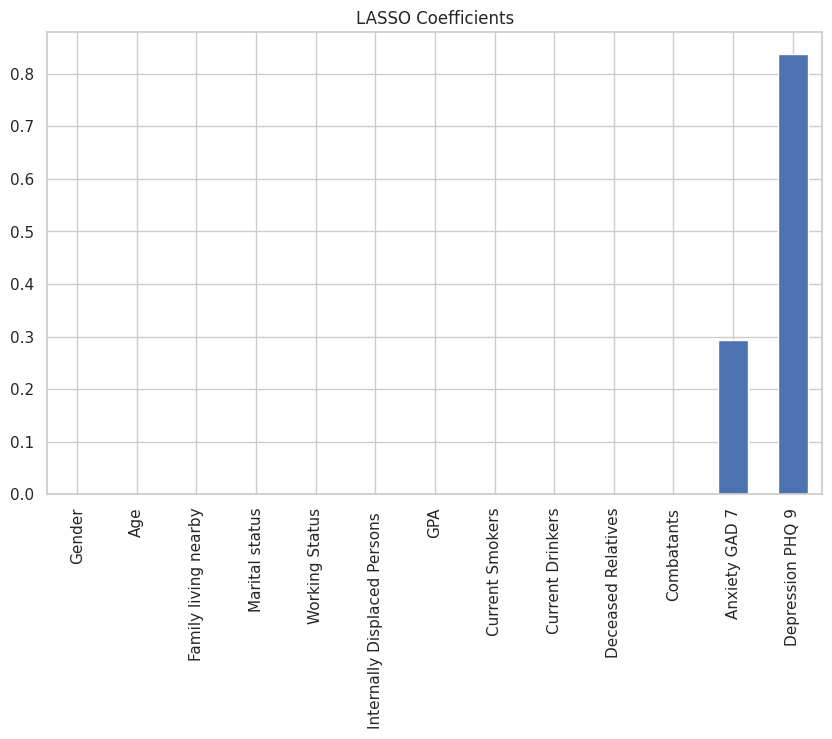

In [37]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# стандартизуємо X
scaler = StandardScaler()
X_std = scaler.fit_transform(df[features].fillna(0))
y_vec = df["Vulnerability"].values

# LASSO Logistic Regression (з крос-валідацією)
lasso = LogisticRegressionCV(
    Cs=50, cv=5, penalty="l1", solver="saga", random_state=42, max_iter=5000
)
lasso.fit(X_std, y_vec)

# коефіцієнти
coef = pd.Series(lasso.coef_.ravel(), index=features)
selected = coef[coef != 0]
print("Вибрані ознаки:", list(selected.index))

# --- графік коефіцієнтів ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
coef.plot(kind="bar")
plt.title("LASSO Coefficients")
plt.show()


[INFO] coef features=14 > names=13 -> додано 1 технічних назв.


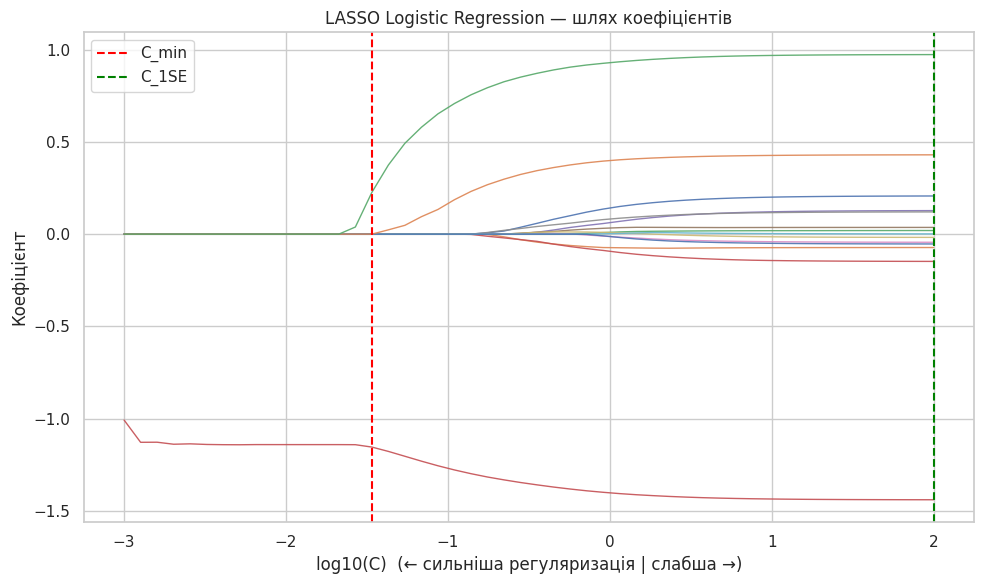

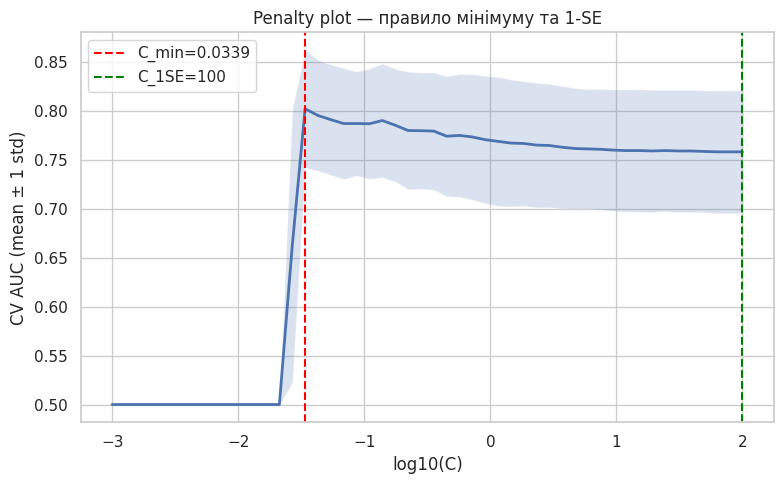


Відібрані фічі при C_min:


,coef
feat_13,-1.154783
Depression PHQ 9,0.226577



Відібрані фічі при C_1SE (простішa модель):


,coef
feat_13,-1.440430
Depression PHQ 9,0.973602
Anxiety GAD 7,0.430030
Gender,0.206892
Marital status,-0.147900
Working Status,0.127567
Current Smokers,0.120513
Age,-0.072614
Сombatants,-0.053338
GPA,-0.044096


In [40]:
# 7) Узгодження імен ознак із кількістю коефіцієнтів
n_path_feats = coef_mean_path.shape[1]
names_len = len(X_cols)

if n_path_feats == names_len:
    feat_names_for_plot = list(X_cols)
elif n_path_feats > names_len:
    # бракує назв — додамо технічні ярлики
    missing = n_path_feats - names_len
    extra = [f"feat_{i}" for i in range(names_len, names_len + missing)]
    feat_names_for_plot = list(X_cols) + extra
    print(f"[INFO] coef features={n_path_feats} > names={names_len} -> додано {missing} технічних назв.")
else:
    # коефіцієнтів менше ніж назв — підріжемо
    feat_names_for_plot = list(X_cols[:n_path_feats])
    print(f"[INFO] coef features={n_path_feats} < names={names_len} -> взято перші {n_path_feats} назв.")

# 8) Coefficient profile plot (криві “шляху”)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for j in range(n_path_feats):
    plt.plot(np.log10(lasso_cv.Cs_), coef_mean_path[:, j], lw=1, alpha=0.9)
plt.axvline(np.log10(C_min), color='red', ls='--', label='C_min')
plt.axvline(np.log10(C_1se), color='green', ls='--', label='C_1SE')
plt.xlabel('log10(C)  (← сильніша регуляризація | слабша →)')
plt.ylabel('Коефіцієнт')
plt.title('LASSO Logistic Regression — шлях коефіцієнтів')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Penalty plot (CV AUC vs C) з позначенням C_min та C_1SE
plt.figure(figsize=(8,5))
plt.plot(np.log10(lasso_cv.Cs_), auc_mean, lw=2)
plt.fill_between(np.log10(lasso_cv.Cs_), auc_mean - auc_std, auc_mean + auc_std, alpha=0.2)
plt.axvline(np.log10(C_min), color='red', ls='--', label=f'C_min={C_min:.3g}')
plt.axvline(np.log10(C_1se), color='green', ls='--', label=f'C_1SE={C_1se:.3g}')
plt.xlabel('log10(C)')
plt.ylabel('CV AUC (mean ± 1 std)')
plt.title('Penalty plot — правило мінімуму та 1-SE')
plt.legend()
plt.tight_layout()
plt.show()

# 10) Відібрані ознаки при C_min і C_1SE
coef_at_Cmin = coef_mean_path[idx_min, :]
coef_at_C1se = coef_mean_path[idx_1se, :]

sel_min = pd.Series(coef_at_Cmin, index=feat_names_for_plot)
sel_1se = pd.Series(coef_at_C1se, index=feat_names_for_plot)

selected_min = sel_min[sel_min != 0].sort_values(key=np.abs, ascending=False)
selected_1se = sel_1se[sel_1se != 0].sort_values(key=np.abs, ascending=False)

print("\nВідібрані фічі при C_min:")
display(selected_min.to_frame('coef'))

print("\nВідібрані фічі при C_1SE (простішa модель):")
display(selected_1se.to_frame('coef'))

# (Опційно) збереження
pd.DataFrame({'C': lasso_cv.Cs_, 'AUC_mean': auc_mean, 'AUC_std': auc_std}).to_csv('lasso_penalty_curve.csv', index=False)
selected_min.to_csv('lasso_selected_Cmin.csv', header=['coef'])
selected_1se.to_csv('lasso_selected_C1SE.csv', header=['coef'])


In [41]:
import scipy.stats as stats

rows = []
for col in features:
    if df[col].dtype == "object" or len(df[col].unique()) < 10:
        # категоріальна
        ct = pd.crosstab(df[col], df["Vulnerability"])
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        rows.append([col, "categorical", p])
    else:
        # числова
        group0 = df.loc[df["Vulnerability"]==0, col]
        group1 = df.loc[df["Vulnerability"]==1, col]
        stat, p = stats.mannwhitneyu(group0, group1, alternative="two-sided")
        rows.append([col, "numeric", p])

df_uni = pd.DataFrame(rows, columns=["Variable","Type","p_value"])
df_uni.to_excel("univariate_analysis.xlsx", index=False)
display(df_uni)


,Variable,Type,p_value
0,Gender,categorical,4.750239e-01
1,Age,numeric,6.869931e-01
2,Family living nearby,categorical,8.651966e-01
3,Marital status,categorical,7.574591e-01
4,Working Status,categorical,8.008122e-01
5,Internally Displaced Persons,categorical,6.556117e-01
6,GPA,numeric,4.728957e-01
7,Current Smokers,categorical,3.901290e-02
8,Current Drinkers,categorical,8.867504e-01
9,Deceased Relatives,categorical,3.502996e-01


In [42]:
from sklearn.mixture import GaussianMixture

fits = []
for k in [1,2,3,4]:
    gm = GaussianMixture(n_components=k, random_state=42).fit(X_std)
    fits.append([k, gm.aic(X_std), gm.bic(X_std)])

df_fit = pd.DataFrame(fits, columns=["Class","AIC","BIC"])
display(df_fit)


,Class,AIC,BIC
0,1,9241.424607,9608.485232
1,2,5777.000056,6514.650735
2,3,1417.954652,2526.195386
3,4,-2968.943522,-1490.112734


In [43]:
from sklearn.mixture import GaussianMixture
import numpy as np, pandas as pd

X = df[features].fillna(0).values  # ті ж самі фічі, що у моделях

results = []
for k in [1,2,3,4]:
    gm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gm.fit(X)
    aic = gm.aic(X)
    bic = gm.bic(X)
    n = len(X)
    d = X.shape[1] * k  # приблизно число параметрів
    abic = bic - np.log(n)*(d-1)  # наближено "adjusted BIC"

    # Entropy: міра визначеності кластерної належності
    resp = gm.predict_proba(X)
    entropy = 1 - (-np.sum(resp*np.log(resp+1e-12)) / (n*np.log(k)))

    # sample proportions
    labels = gm.predict(X)
    props = np.round(100*np.bincount(labels)/n, 2)
    props_str = "/".join(map(str, props))

    results.append([k, aic, bic, abic, entropy, props_str])

df_gof = pd.DataFrame(results, columns=["Class","AIC","BIC","aBIC","Entropy","Sample proportion (%) per class"])
display(df_gof)
df_gof.to_excel("goodness_of_fit.xlsx", index=False)


/tmp/ipython-input-1635816623.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  entropy = 1 - (-np.sum(resp*np.log(resp+1e-12)) / (n*np.log(k)))


,Class,AIC,BIC,aBIC,Entropy,Sample proportion (%) per class
0,1,6316.901256,6683.961881,6617.608732,inf,100.0
1,2,938.130723,1675.781402,1537.545675,0.999997,25.4/74.6
2,3,446.689821,1554.930554,1344.812249,0.981949,8.73/7.94/83.33
3,4,457.391997,1936.222785,1654.221901,0.999954,3.57/4.76/11.11/80.56


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import resample

import numpy as np, pandas as pd

def bootstrap_auc_ci(model, X, y, n_boot=1000, alpha=0.05):
    """Обчислює AUC та 95% CI бутстрепом"""
    aucs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y), len(y), replace=True)
        if len(np.unique(y[idx])) < 2:
            continue
        y_pred = model.predict_proba(X[idx])[:,1]
        aucs.append(roc_auc_score(y[idx], y_pred))
    if len(aucs) == 0:
        return np.nan, (np.nan, np.nan)
    lower = np.percentile(aucs, 100*alpha/2)
    upper = np.percentile(aucs, 100*(1-alpha/2))
    return np.mean(aucs), (lower, upper)

def eval_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)

    results = {}
    for split, X, y in [("Train", X_train, y_train), ("Validation", X_test, y_test)]:
        y_pred = model.predict(X)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:,1]
        else:
            y_proba = model.decision_function(X)

        auc, (ci_low, ci_high) = bootstrap_auc_ci(model, X, y)

        acc = accuracy_score(y, y_pred)
        sens = recall_score(y, y_pred, pos_label=1)
        spec = recall_score(y, y_pred, pos_label=0)
        ppv  = precision_score(y, y_pred, pos_label=1, zero_division=0)
        npv  = precision_score(y, y_pred, pos_label=0, zero_division=0)
        f1   = f1_score(y, y_pred, pos_label=1)

        results[(split, name)] = {
            "AUC (95% CI)": f"{auc:.3f} ({ci_low:.3f}, {ci_high:.3f})",
            "Accuracy": round(acc,3),
            "Sensitivity": round(sens,3),
            "Specificity": round(spec,3),
            "PPV": round(ppv,3),
            "NPV": round(npv,3),
            "F1score": round(f1,3)
        }
    return results

# 🔹 Список моделей
models = {
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LR": LogisticRegression(max_iter=1000, solver='liblinear'),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "GNB": GaussianNB(),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

all_results = {}
for name, model in models.items():
    res = eval_model(model, X_train, y_train, X_test, y_test, name)
    all_results.update(res)

# 🔹 Формуємо дві таблиці
train_table = pd.DataFrame({m: all_results[("Train", m)] for m in models}).T
val_table   = pd.DataFrame({m: all_results[("Validation", m)] for m in models}).T

print("=== Training set ===")
display(train_table)

print("\n=== Validation set ===")
display(val_table)

# Зберегти у Excel
with pd.ExcelWriter("predictive_performance.xlsx") as writer:
    train_table.to_excel(writer, sheet_name="Training")
    val_table.to_excel(writer, sheet_name="Validation")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:33:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Training set ===


,AUC (95% CI),Accuracy,Sensitivity,Specificity,PPV,NPV,F1score
XGBoost,"1.000 (1.000, 1.000)",1.0,1.0,1.0,1.0,1.0,1.0
LR,"0.817 (0.756, 0.877)",0.786,0.327,0.934,0.615,0.811,0.427
RF,"1.000 (1.000, 1.000)",1.0,1.0,1.0,1.0,1.0,1.0
AdaBoost,"0.859 (0.804, 0.906)",0.796,0.449,0.908,0.611,0.836,0.518
GBDT,"0.994 (0.980, 1.000)",0.98,0.939,0.993,0.979,0.981,0.958
GNB,"0.777 (0.701, 0.846)",0.736,0.469,0.822,0.46,0.828,0.465
MLP,"0.846 (0.788, 0.902)",0.776,0.122,0.987,0.75,0.777,0.211
SVM,"0.927 (0.877, 0.965)",0.821,0.306,0.987,0.882,0.815,0.455



=== Validation set ===


,AUC (95% CI),Accuracy,Sensitivity,Specificity,PPV,NPV,F1score
XGBoost,"0.745 (0.565, 0.895)",0.725,0.333,0.846,0.4,0.805,0.364
LR,"0.733 (0.517, 0.910)",0.804,0.25,0.974,0.75,0.809,0.375
RF,"0.806 (0.621, 0.942)",0.804,0.333,0.949,0.667,0.822,0.444
AdaBoost,"0.774 (0.581, 0.934)",0.804,0.417,0.923,0.625,0.837,0.5
GBDT,"0.829 (0.683, 0.947)",0.804,0.5,0.897,0.6,0.854,0.545
GNB,"0.824 (0.600, 0.974)",0.824,0.667,0.872,0.615,0.895,0.64
MLP,"0.803 (0.623, 0.944)",0.804,0.167,1.0,1.0,0.796,0.286
SVM,"0.748 (0.565, 0.911)",0.804,0.167,1.0,1.0,0.796,0.286


In [45]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, brier_score_loss,
                             confusion_matrix, classification_report)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# 1) Опис моделей (можеш підправити гіперпараметри за бажанням)
models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=4, random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False),
    "LR": LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "GNB": GaussianNB(),
    "MLP": None,  # додамо нижче, якщо вже імпортовано
    "SVM": SVC(probability=True, random_state=42)
}

# MLP (якщо ти вже імпортувала раніше — можна використати свій)
from sklearn.neural_network import MLPClassifier
models["MLP"] = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)

# 2) Навчимо всі моделі на train (на всяк випадок, щоб гарантовано були навчені)
fitted = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    fitted[name] = mdl
print("Trained models:", list(fitted.keys()))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:37:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Trained models: ['DecisionTree', 'XGBoost', 'LR', 'RF', 'AdaBoost', 'GBDT', 'GNB', 'MLP', 'SVM']


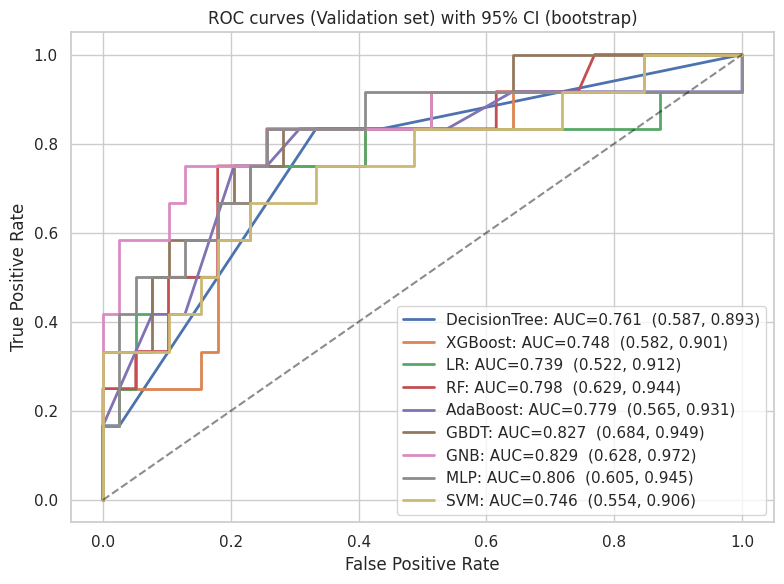

In [46]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

def bootstrap_roc_ci(model, X, y, n_boot=1000, alpha=0.05):
    aucs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y), len(y), replace=True)
        y_b = y[idx]
        if len(np.unique(y_b))<2:  # пропускаємо бутстреп без двох класів
            continue
        y_p = model.predict_proba(X[idx])[:,1]
        aucs.append(roc_auc_score(y_b, y_p))
    if len(aucs)==0:
        return np.nan, (np.nan, np.nan)
    return np.mean(aucs), (np.percentile(aucs, 2.5), np.percentile(aucs, 97.5))

plt.figure(figsize=(8,6))
for name, mdl in fitted.items():
    y_proba = mdl.predict_proba(X_test)[:,1] if hasattr(mdl,'predict_proba') else mdl.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    mu, (lo, hi) = bootstrap_roc_ci(mdl, X_test, y_test, n_boot=1000)
    label = f"{name}: AUC={roc_auc:.3f}  ({lo:.3f}, {hi:.3f})"
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (Validation set) with 95% CI (bootstrap)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


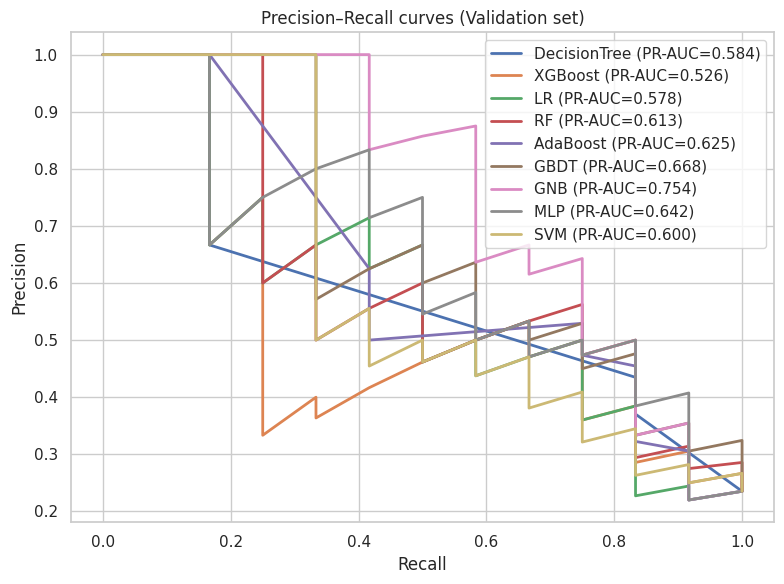

In [47]:
plt.figure(figsize=(8,6))
for name, mdl in fitted.items():
    y_proba = mdl.predict_proba(X_test)[:,1] if hasattr(mdl,'predict_proba') else mdl.decision_function(X_test)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, lw=2, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curves (Validation set)")
plt.legend()
plt.tight_layout()
plt.show()


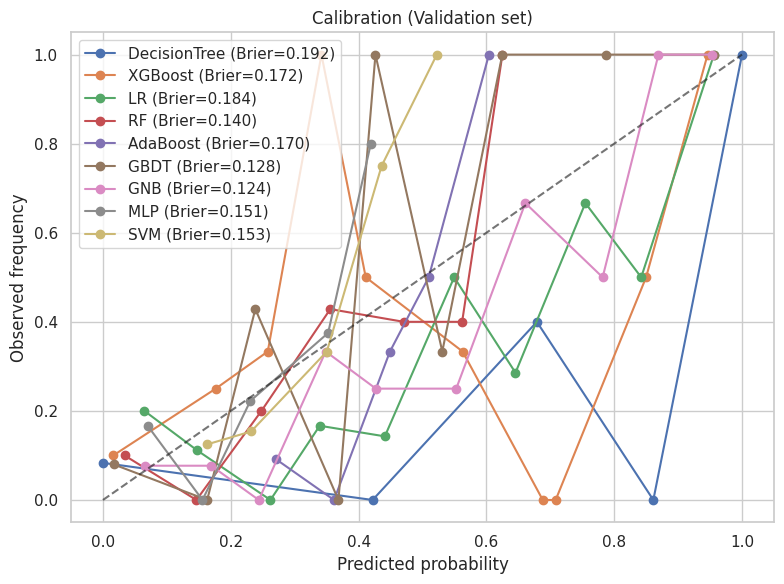

In [48]:
plt.figure(figsize=(8,6))
for name, mdl in fitted.items():
    if not hasattr(mdl, 'predict_proba') and not hasattr(mdl, 'decision_function'):
        continue
    y_proba = mdl.predict_proba(X_test)[:,1] if hasattr(mdl,'predict_proba') else 1/(1+np.exp(-mdl.decision_function(X_test)))
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')
    bs = brier_score_loss(y_test, y_proba)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{name} (Brier={bs:.3f})")

plt.plot([0,1],[0,1],'k--',alpha=0.6)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration (Validation set)")
plt.legend()
plt.tight_layout()
plt.show()


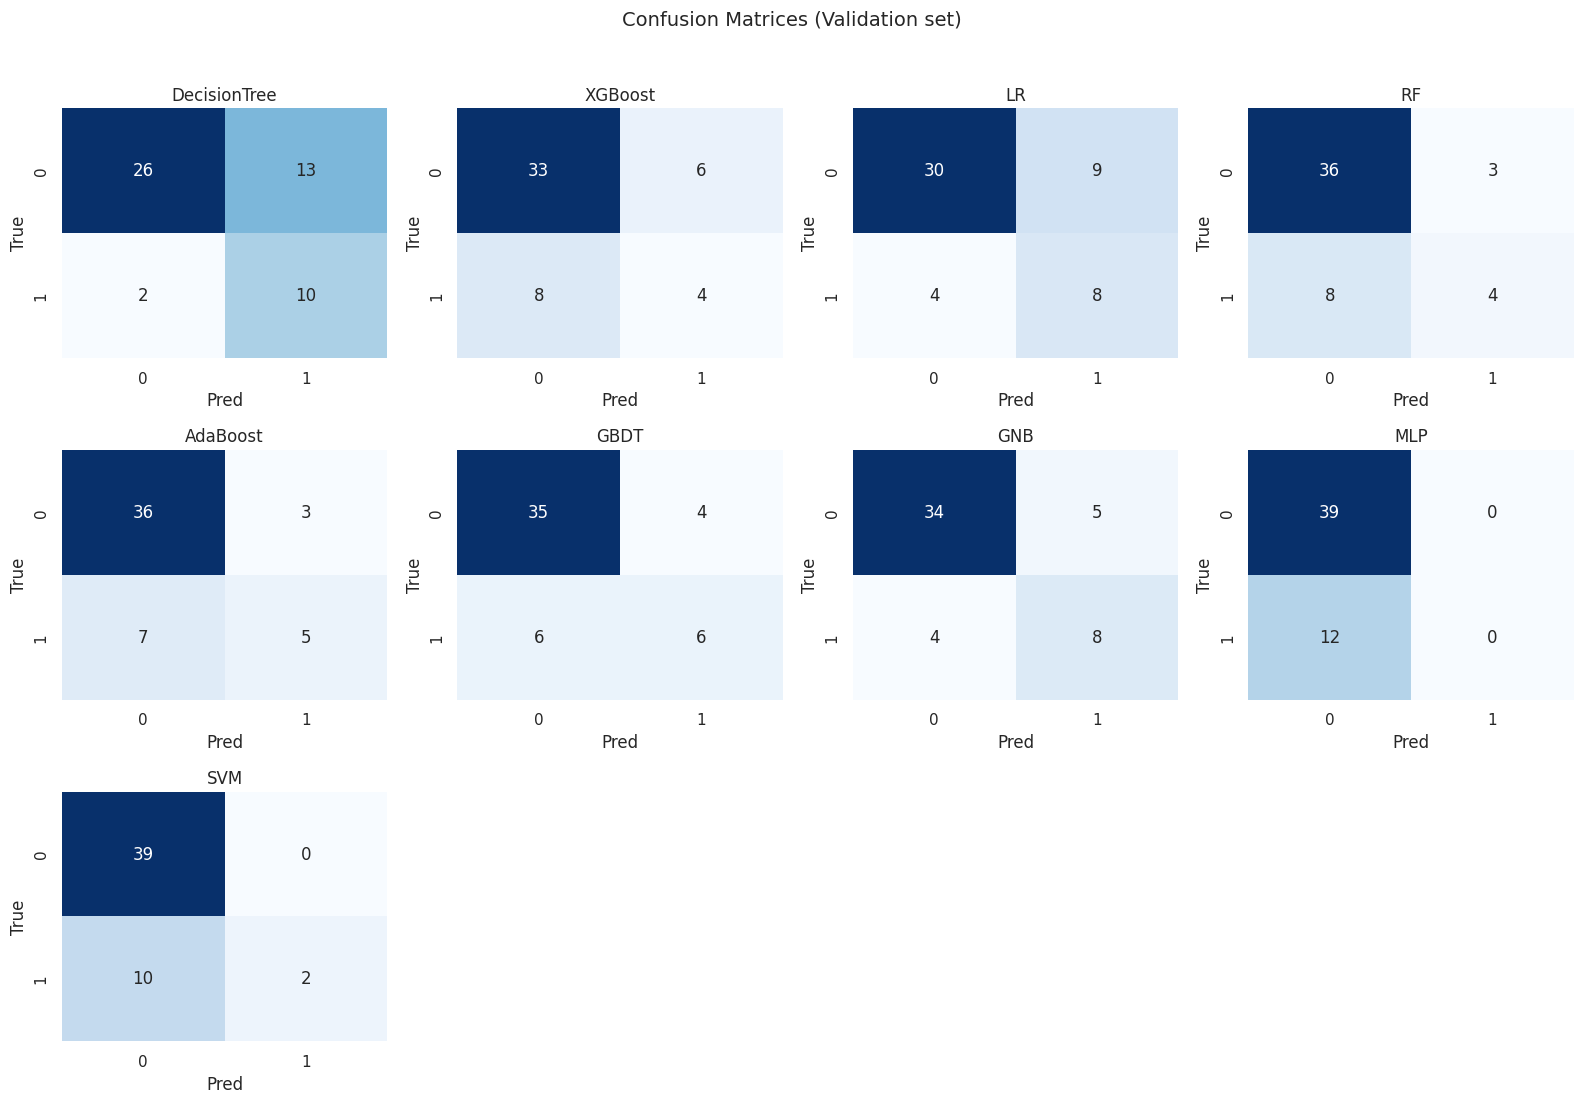

In [49]:
import math
n = len(fitted)
cols = 4
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.6*rows))
axes = axes.ravel()

for ax, (name, mdl) in zip(axes, fitted.items()):
    y_pred = mdl.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Pred'); ax.set_ylabel('True')

# порожні осередки (якщо моделей менше, ніж сітка) приберемо
for i in range(len(fitted), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Confusion Matrices (Validation set)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


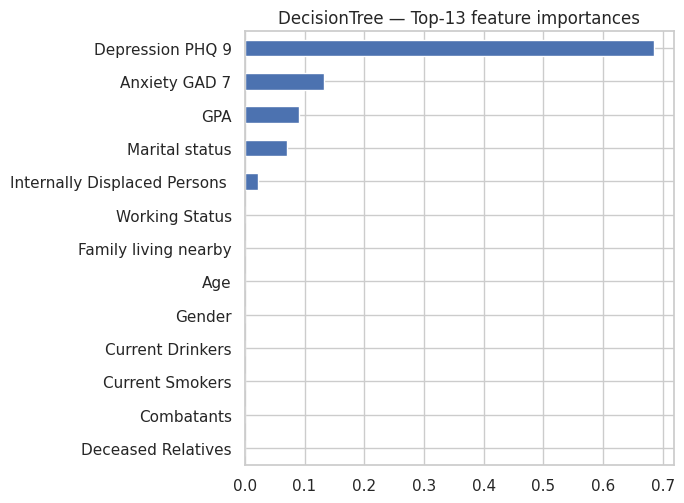

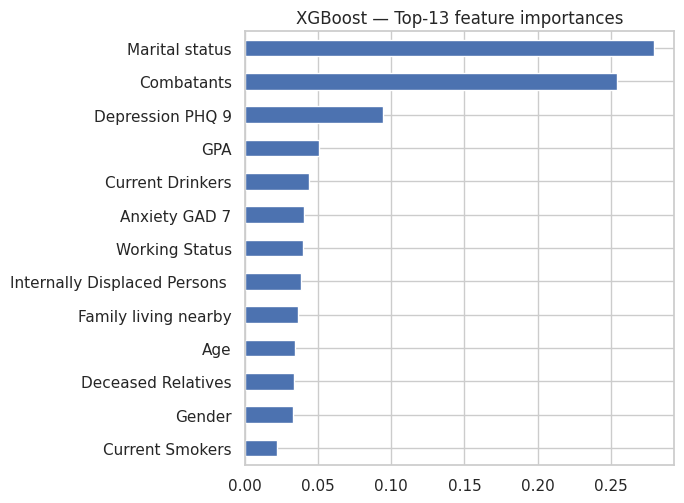

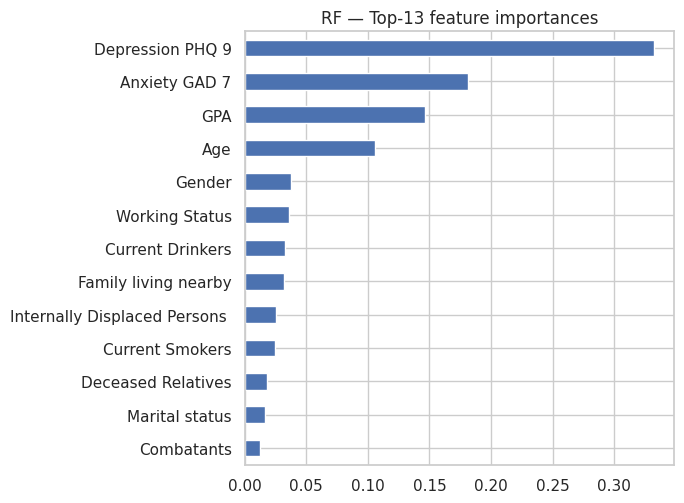

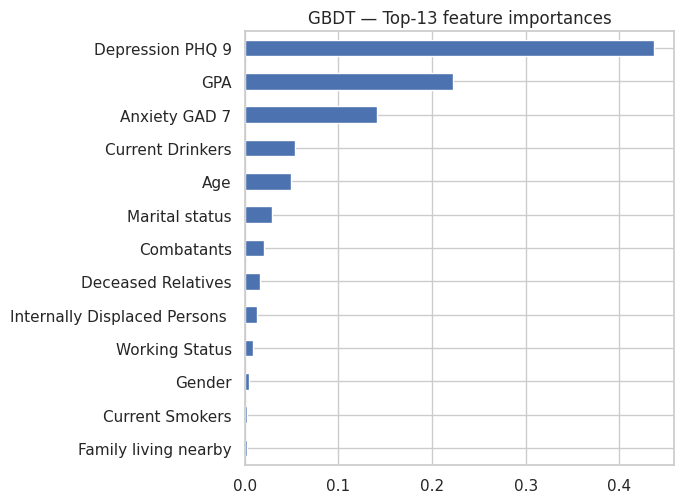

In [50]:
def plot_importance(model, model_name, features, top=15):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:top]
        plt.figure(figsize=(7, max(4, 0.4*len(imp))))
        imp.iloc[::-1].plot(kind='barh')
        plt.title(f"{model_name} — Top-{len(imp)} feature importances")
        plt.tight_layout()
        plt.show()

for name in ["DecisionTree","XGBoost","RF","GBDT"]:
    if name in fitted:
        plot_importance(fitted[name], name, features, top=15)


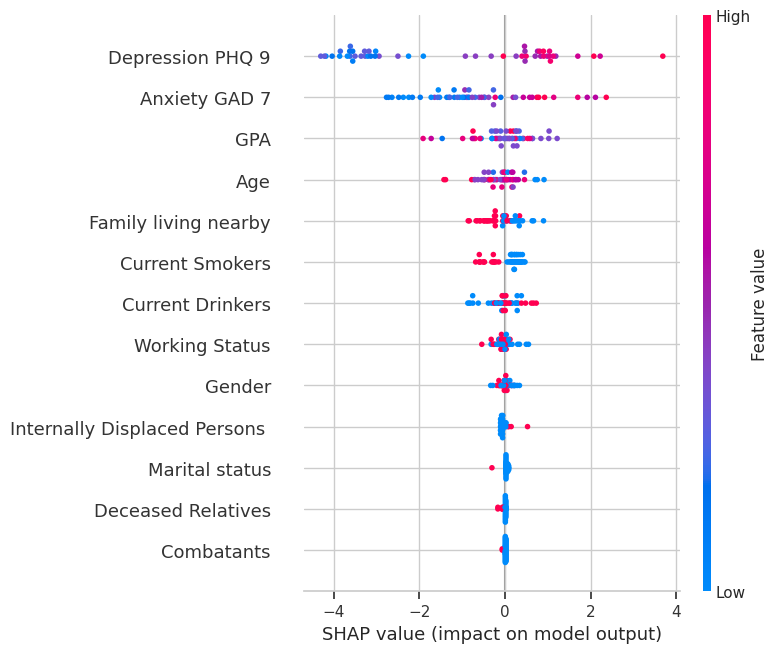

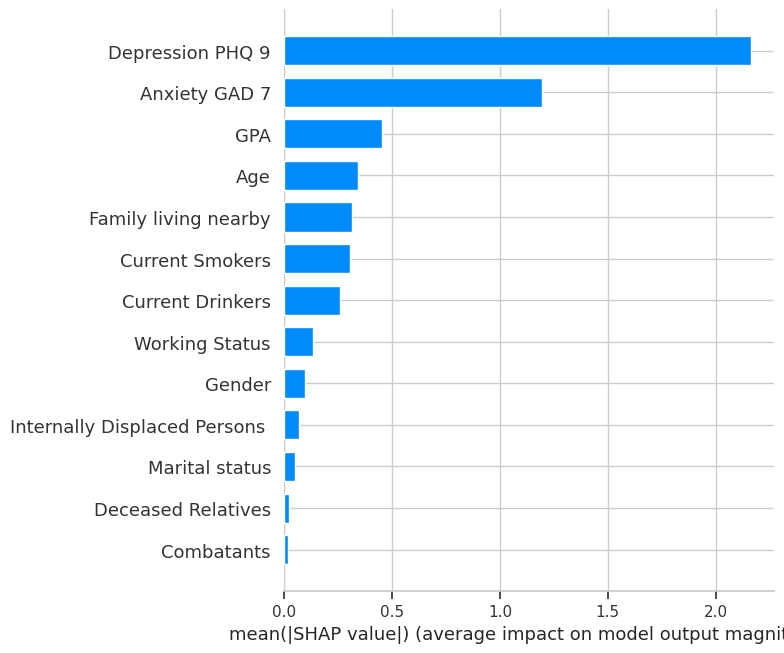

In [51]:
!pip -q install shap
import shap, numpy as np
xgb_model = fitted["XGBoost"]
explainer = shap.TreeExplainer(xgb_model)
# невелика вибірка для швидкості
idx = np.random.choice(X_test.shape[0], min(200, X_test.shape[0]), replace=False)
X_te_small = X_test[idx]
shap_vals = explainer.shap_values(X_te_small)
shap.summary_plot(shap_vals, pd.DataFrame(X_te_small, columns=features), show=True)
shap.summary_plot(shap_vals, pd.DataFrame(X_te_small, columns=features), plot_type='bar', show=True)


,Model,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
6,GNB,0.829060,0.823529,0.666667,0.871795,0.615385,0.894737,0.640000
5,GBDT,0.826923,0.803922,0.500000,0.897436,0.600000,0.853659,0.545455
7,MLP,0.805556,0.764706,0.000000,1.000000,0.000000,0.764706,0.000000
3,RF,0.798077,0.784314,0.333333,0.923077,0.571429,0.818182,0.421053
4,AdaBoost,0.778846,0.803922,0.416667,0.923077,0.625000,0.837209,0.500000
0,DecisionTree,0.760684,0.705882,0.833333,0.666667,0.434783,0.928571,0.571429
1,XGBoost,0.747863,0.725490,0.333333,0.846154,0.400000,0.804878,0.363636
8,SVM,0.745726,0.803922,0.166667,1.000000,1.000000,0.795918,0.285714
2,LR,0.739316,0.745098,0.666667,0.769231,0.470588,0.882353,0.551724


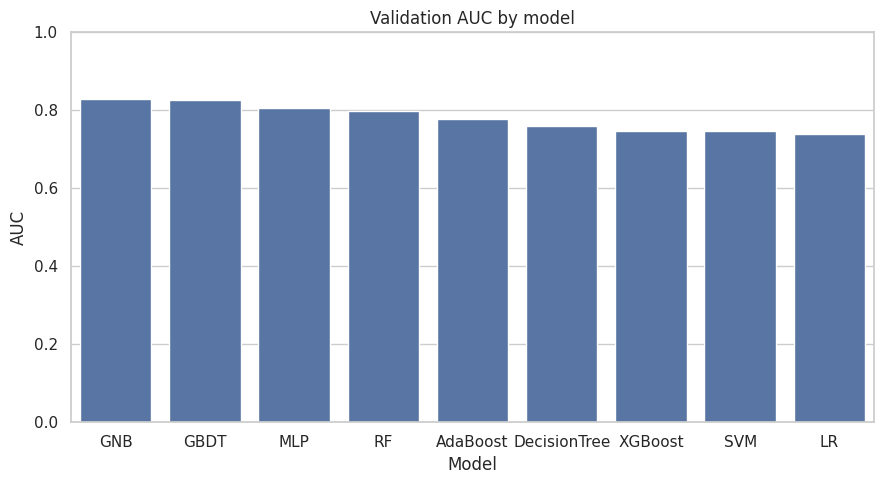

In [52]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

rows = []
for name, mdl in fitted.items():
    y_pred = mdl.predict(X_test)
    y_proba = mdl.predict_proba(X_test)[:,1] if hasattr(mdl,'predict_proba') else mdl.decision_function(X_test)
    rows.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Sensitivity": recall_score(y_test, y_pred, pos_label=1),
        "Specificity": recall_score(y_test, y_pred, pos_label=0),
        "PPV": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "NPV": precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        "F1": f1_score(y_test, y_pred)
    })
df_cmp = pd.DataFrame(rows).sort_values("AUC", ascending=False)
display(df_cmp)

plt.figure(figsize=(9,5))
sns.barplot(data=df_cmp, x="Model", y="AUC")
plt.title("Validation AUC by model")
plt.ylim(0,1)
plt.tight_layout(); plt.show()


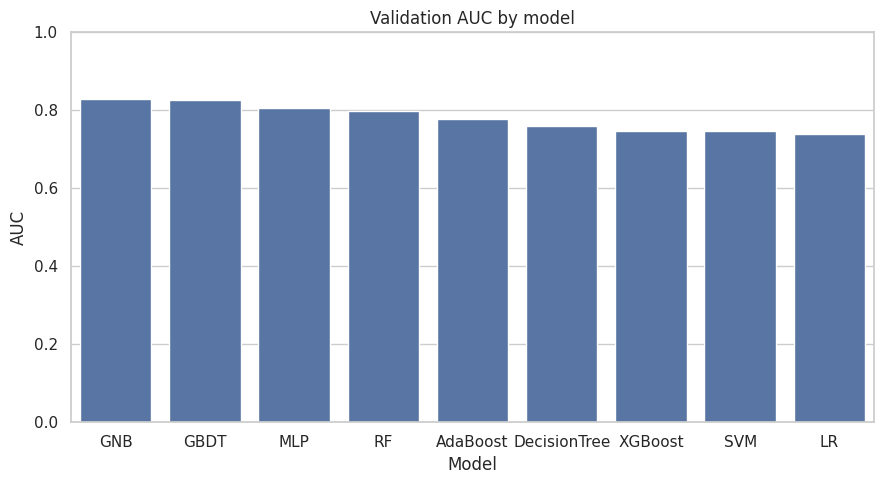

In [53]:
# Приклад: збереження останнього графіка
plt.figure(figsize=(9,5))
sns.barplot(data=df_cmp, x="Model", y="AUC")
plt.title("Validation AUC by model")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("val_auc_by_model.png", dpi=300)
plt.show()
